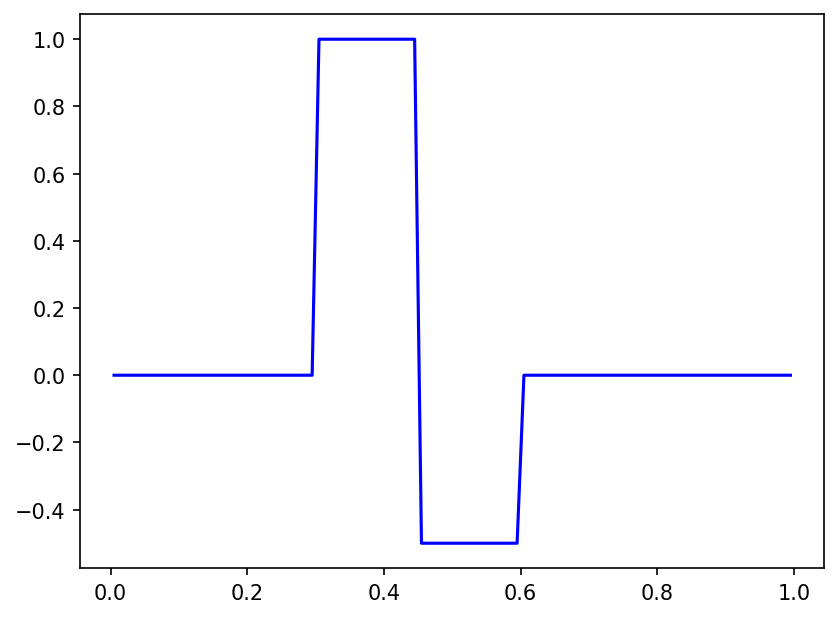

In [169]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from discretize import TensorMesh
from SimPEG import simulation, maps
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 150

nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.cell_centers_x > 0.3] = 1.0
true_model[mesh.cell_centers_x > 0.45] = -0.5
true_model[mesh.cell_centers_x > 0.6] = 0

# Plotting the true model
plt.plot(mesh.cell_centers_x, true_model, "b-")

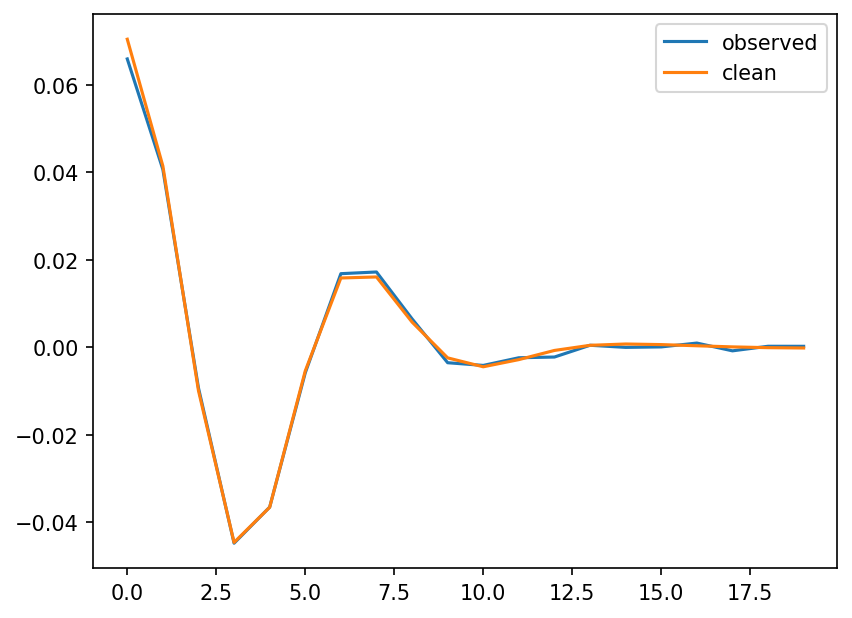

In [170]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial.
# The columns of the linear operator represents a set of decaying and oscillating functions.
sim = simulation.ExponentialSinusoidSimulation(
    model_map=maps.IdentityMap(), mesh=mesh, n_kernels=nData, p=-0.25, q=0.25, j0=1, jn=60
)
G = sim.G

# Standard deviation of Gaussian noise being added
data_std = 0.001
np.random.seed(3211)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, noise_floor=data_std, add_noise=True)

plt.plot(data_obj.dobs, label='observed')
plt.plot(data_obj.dclean, label='clean')
plt.legend()

3888.8673434670013 753.2177932338451
(100, 100) (100,)


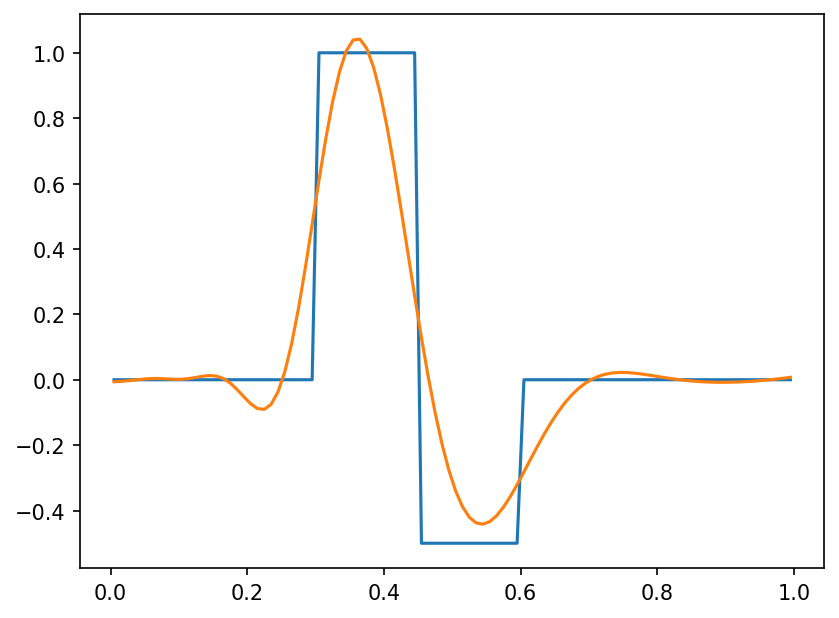

In [409]:
model_std = 0.4
Wd = np.diag(1/data_obj.standard_deviation)

A = G.T @ Wd.T @ Wd @ G + 1/model_std**2 * np.eye(G.shape[1])
b = G.T @ Wd.T @ Wd @  data_obj.dobs
print(np.linalg.norm(A), np.linalg.norm(b))
print(A.shape, b.shape)
m_max_post = np.linalg.solve(A, b)

del_d = Wd @ (G @ m_max_post - data_obj.dobs)
# print(del_d.T @ del_d)

plt.plot(mesh.cell_centers_x, true_model)
plt.plot(mesh.cell_centers_x, m_max_post)

plt.show()

# plt.hist((G.T @ Wd.T @ Wd @ data_obj.dobs).flatten())
# plt.show()
# plt.hist((1/model_std**2 * np.eye(G.shape[1])).flatten())

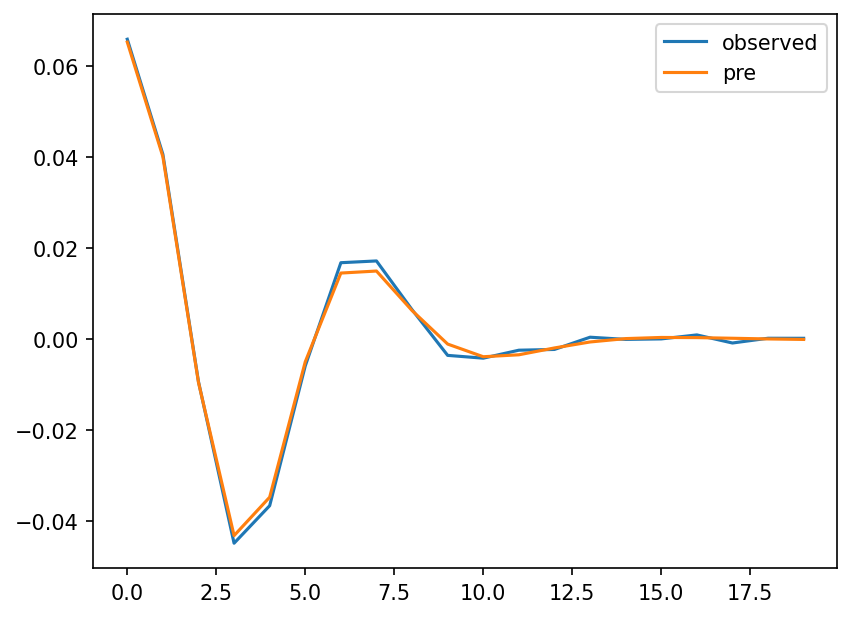

In [172]:
plt.plot(data_obj.dobs, label='observed')
plt.plot(G @ m_max_post, label='pre')
plt.legend()

## Create the perturbed data distrubution

(20, 20) (1, 20)


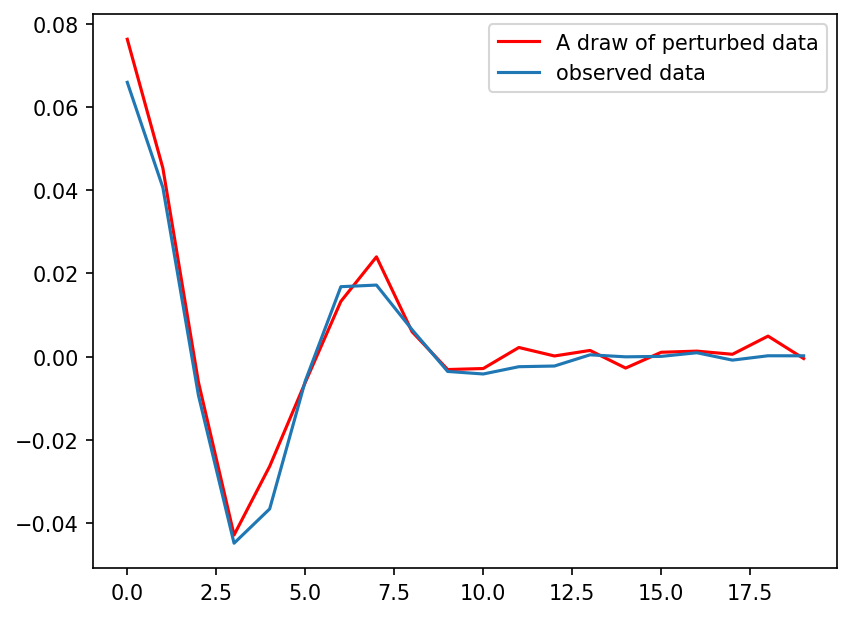

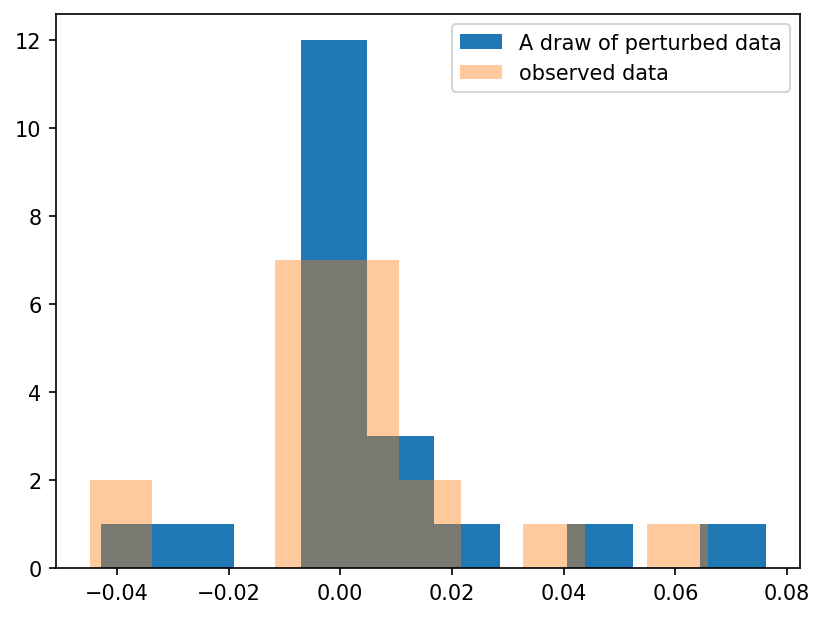

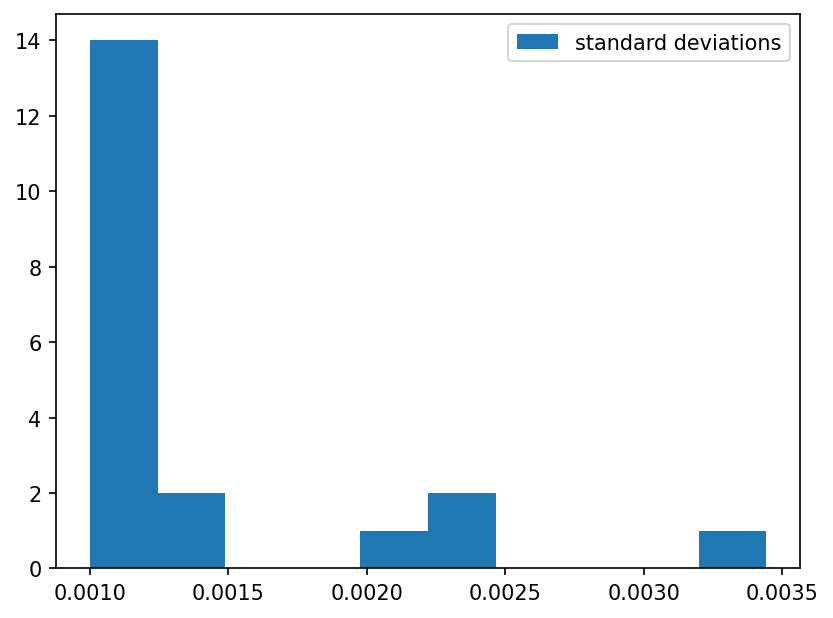

In [173]:
# Generate sample data
np.random.seed(0)

n_samples = 1000
n_components = 20
Wd = np.diag(data_obj.standard_deviation * 1e-2)

# Generate two Gaussian distribution
perturbed_data = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)

plt.plot(perturbed_data.T, 'r', label='A draw of perturbed data')
plt.plot(data_obj.dobs, label='observed data')
print(Wd.shape, perturbed_data.shape)
plt.legend()
plt.show()

plt.hist(perturbed_data.mean(axis=0), label='A draw of perturbed data')
plt.hist(data_obj.dobs, alpha=0.4, label='observed data')
plt.legend()
plt.show()

plt.hist(data_obj.standard_deviation, label='standard deviations')
plt.legend()
plt.show()

## create distrubution for perturbed model

(100, 100)
(1, 100) (100, 100)
(100, 1)


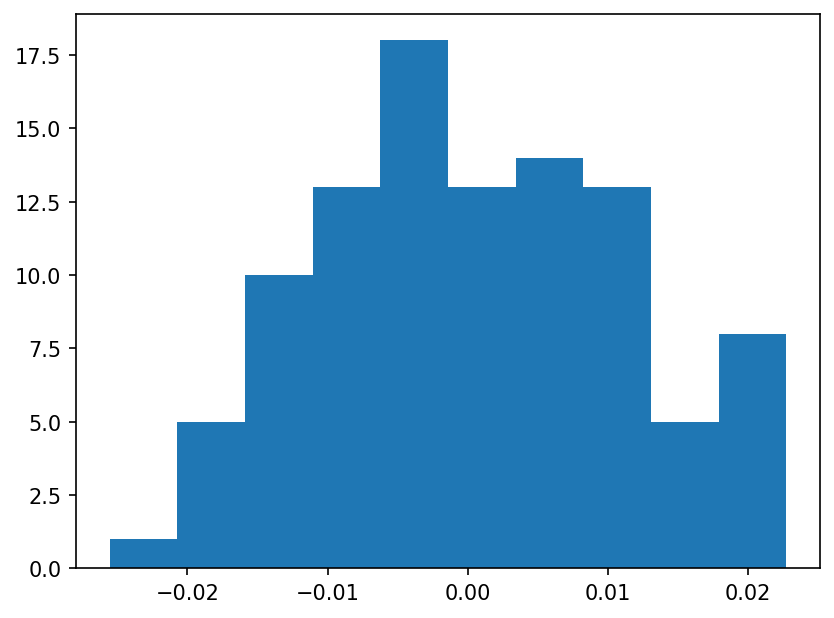

In [174]:
from scipy import linalg
mean = 0
mu = 1e4 #np.mean(data_obj.dobs)

identity_matrix = np.eye(100)
print(identity_matrix.shape)
zero_means = np.zeros(100)

s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

# coefficient matrix
Wm = np.sqrt(mu) * np.eye(100)
print(s.shape, Wm.shape)
perturbed_model = np.linalg.solve(Wm, s.T)
print(perturbed_model.shape)
plt.hist(perturbed_model)
plt.show()


In [459]:
draws = []

Wm = linalg.inv(Wd)
mu = 4.0
Wd = np.diag(1/data_obj.standard_deviation)

A = G.T @ Wd.T @ Wd @ G + mu * np.eye(G.shape[1])
b = G.T @ Wd.T @ Wd @ perturbed_data.T + mu * np.eye(G.shape[1]) @ perturbed_model


# m_max_post = np.linalg.solve(A, b)
draws = m_max_post
# draws = np.hstack(draws)
# print(A.shape, b.shape, (G.T @ Wd.T @ Wd @ perturbed_data.T).shape )
# plt.plot(draws)
# plt.plot(data_obj.dobs, 'r')

# plt.hist((G.T @ Wd.T @ Wd @ perturbed_data.T).flatten())
# plt.show()
# plt.hist((mu * np.eye(G.shape[1]) @ perturbed_model).flatten())

# mu = 1e3
# A = G.T @ Wd.T @ Wd @ G
# b = G.T @ Wd.T @ Wd @ perturbed_data.T + mu / 2


# m_max_post_l1 = np.linalg.solve(A, b)
# draws = m_max_post
# # draws = np.hstack(draws)
# print((G.T @ Wd.T @ Wd @ G).shape, (mu * np.eye(G.shape[1])).shape)
# # plt.plot(draws)
# # plt.plot(data_obj.dobs, 'r')

# plt.hist((G.T @ Wd.T @ Wd @ perturbed_data.T).flatten())
# plt.show()
# plt.hist((mu * np.eye(G.shape[1]) @ perturbed_model).flatten())

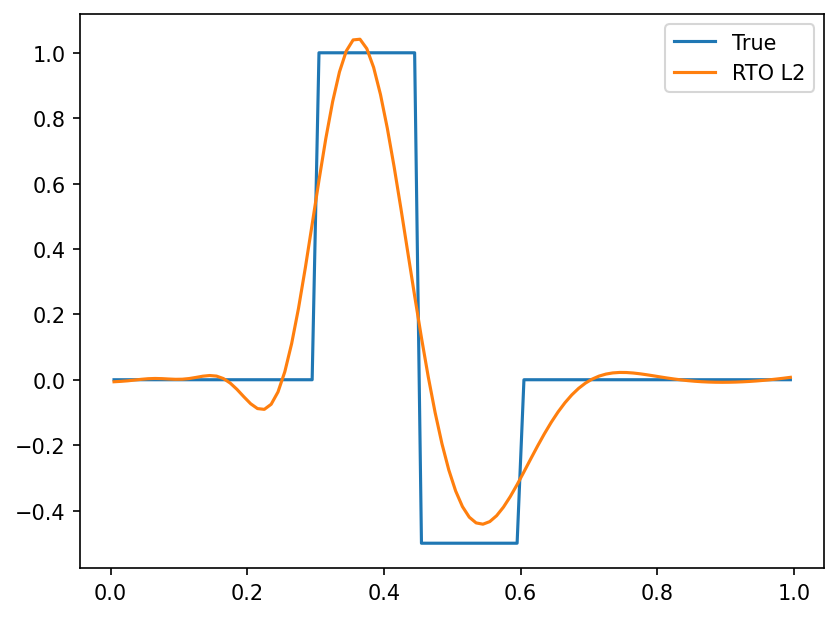

In [460]:
plt.plot(mesh.cell_centers_x, true_model, label='True')
plt.plot(mesh.cell_centers_x, draws, label='RTO L2')
# plt.plot(mesh.cell_centers_x, m_max_post_l1, label='RTOL1')
plt.legend()

## create function to perform rto

In [694]:
def randomize_them_optimize(
        
        dobs:np.ndarray,
        n_samples:int=50,
        n_model_samples:int=100,
        n_components:int=20,
        mu_init:float=1e1,
        mu_perturb:float=1e4,
        standard_deviation:np.ndarray=None,
        TKO: bool=False
        
    ) -> np.ndarray:

    # Generate sample data
    np.random.seed(0)

    # data covariace matrix to perturb data
    Wd = np.diag(standard_deviation)

    # model zero mean guassian distribution
    identity_matrix = np.eye(n_model_samples)
    zero_means = np.zeros(n_model_samples)

    draws = []
    draws_mu = []

    for ii in range(n_samples):
    
        # draw from perturbed data distribution
        perturbed_data = np.random.multivariate_normal(dobs, Wd, size=1)

        # draw from perturbed model distribution
        s = np.random.multivariate_normal(zero_means, identity_matrix, size=1)

        # coefficient matrix
        Wm = np.sqrt(mu_perturb) * np.eye(n_model_samples)
        
        # solve linear equation for perturbed model
        perturbed_model = np.linalg.solve(Wm, s.T)

        # data covariance matrix
        Cd = np.diag(1 / standard_deviation)

        # solve foe model
        A = G.T @ Cd.T @ Cd @ G + mu_init * np.eye(G.shape[1])
        b = G.T @ Cd.T @ Cd @ perturbed_data.T + mu_init * np.eye(G.shape[1]) @ perturbed_model
        m_max_post = np.linalg.solve(A, b)

        lower, upper = 0.5, 10
        
        if TKO:
            perturbed_data2 = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)
            mu_new = tko(G, perturbed_data2, Cd, m_max_post, mu_init)
            # mu_init = mu_new
            if lower < mu_new < upper:
                print(f"using mu: {mu_new} {mu_init}")
                draws_mu.append(mu_new[0])

        draws.append(m_max_post)
        
    if TKO:
        
        return np.hstack(draws), np.hstack(draws_mu) 
    
    return np.hstack(draws)

def tko(for_mat, perturbed_data_2, Cd, rto_model, mu_ref):

    G = for_mat.copy()
    initial_x = 20

    # Example usage with the function f(x) = x^2 - 4x + 4
    def objective_func(mu):
        r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T
        return 0.5 * np.linalg.norm(r)

    def gradient_func(mu):
        A = rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model
        B = rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
        return np.sqrt(mu_ref / mu) * A - B

    def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x:float):
        x = initial_x

        for i in range(iterations):

            xprev = np.array([x]).copy()

            # get residual
            r = objective_func(x)

            # Calculate the gradient at the current point
            grad = gradient_func(x)

            Ag = G * grad
            alpha = (r*Ag).mean()/(Ag*Ag).mean()
            
            # Update x using the gradient and learning rate
            # update = learning_rate * grad
            # print(f"alpha: {alpha}")

            x -= learning_rate * alpha * grad

            value = objective_func(x)
            # print(f"r: {r}, f(x): {value}")
            # if r < value:
            #     x = xprev[0]
            #     x -= learning_rate * alpha * grad
                # return xprev[0]

            if np.isnan(value):
        
                return xprev[0]
            
            # if (value < 0):
        
            #     return xprev

            # Print the current iteration and the value of the objective function
            # print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        
        return x.copy()

    learning_rate = 1e-3
    iterations = 50

    result = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)
    # print("Final result: x =", result, mu_ref)

    return result

    
    

In [697]:
rto_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=1000,
        n_model_samples=100,
        n_components=20,
        mu_init=3,
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        
)

tko_results, mu_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=100,
        n_model_samples=100,
        n_components=20,
        mu_init=40,
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        TKO=True
        
)
print(f" mean: {mu_results.mean()}")
rto_tko_results = randomize_them_optimize(
        
        data_obj.dobs,
        n_samples=1000,
        n_model_samples=100,
        n_components=20,
        mu_init=mu_results.mean(),
        mu_perturb=1e4,
        standard_deviation=data_obj.standard_deviation,
        
)

# rto_results2 = randomize_them_optimize(
        
#         data_obj.dobs,
#         n_samples=1000,
#         n_model_samples=100,
#         n_components=20,
#         mu_init=3.5,
#         mu_perturb=1e4,
#         standard_deviation=data_obj.standard_deviation,
        
# )

C:\Users\johnk\AppData\Local\Temp\ipykernel_10548\3434640843.py:74: RuntimeWarning: invalid value encountered in sqrt
  r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T


using mu: [[4.89459017]] 40
using mu: [[5.99712244]] 40
using mu: [[7.45758446]] 40
using mu: [[2.81515013]] 40
using mu: [[6.80618182]] 40
using mu: [[3.22412087]] 40
using mu: [[5.78999631]] 40
using mu: [[2.53464481]] 40
using mu: [[4.75485296]] 40
using mu: [[2.04852442]] 40
using mu: [[3.76769859]] 40
using mu: [[3.5988854]] 40
using mu: [[6.69235708]] 40
using mu: [[1.23512882]] 40
using mu: [[3.62135267]] 40
using mu: [[0.95846779]] 40
using mu: [[5.16112899]] 40
using mu: [[5.71508826]] 40
using mu: [[0.60415454]] 40
using mu: [[3.71737368]] 40
using mu: [[6.99318138]] 40
using mu: [[6.43821642]] 40
using mu: [[2.46703348]] 40
using mu: [[5.12089974]] 40
using mu: [[3.75134174]] 40
using mu: [[1.06451314]] 40
using mu: [[1.64591795]] 40
using mu: [[5.19226739]] 40
using mu: [[1.74634551]] 40
using mu: [[1.5191939]] 40
using mu: [[0.82212954]] 40
using mu: [[1.71516259]] 40
using mu: [[4.14683031]] 40
using mu: [[2.08220409]] 40
using mu: [[1.79808043]] 40
using mu: [[6.98239495

(100, 1000)


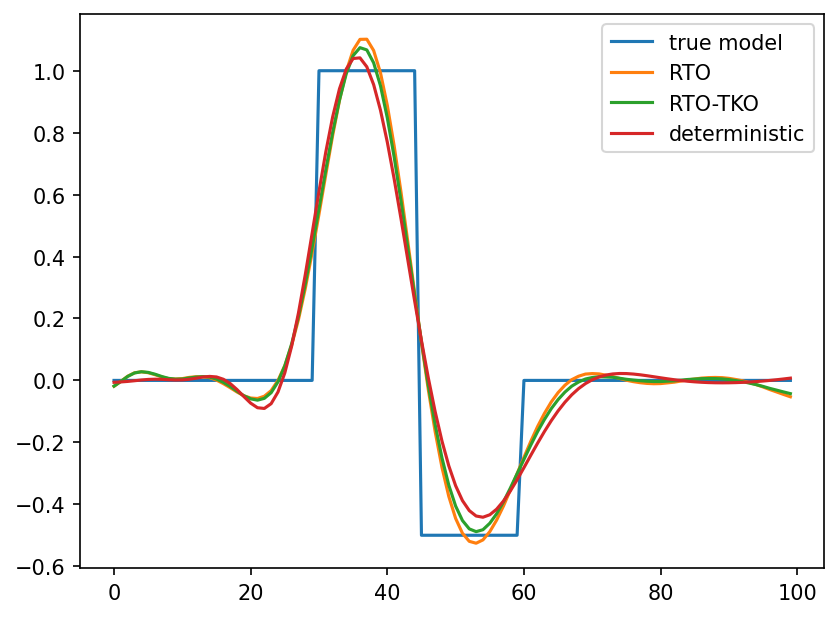

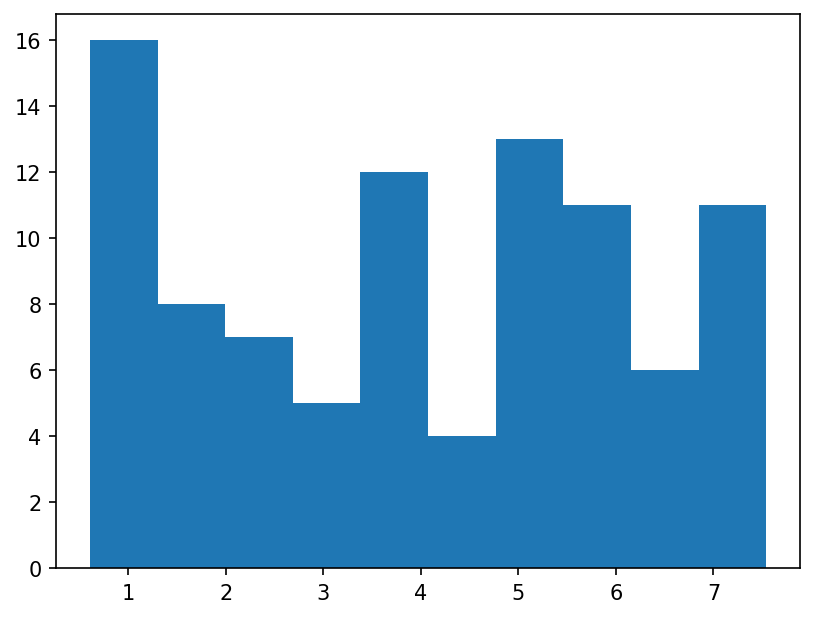

In [698]:
print(results.shape)
plt.plot(true_model, label='true model')
plt.plot(rto_results.mean(axis=1), label='RTO')
plt.plot(rto_tko_results.mean(axis=1), label='RTO-TKO')
# plt.plot(rto_results[:, 1], label='RTO1')
# plt.plot(rto_results2.mean(axis=1), label='RTO2')
plt.plot(m_max_post, label='deterministic')
plt.legend()
plt.show()

plt.hist(mu_results.flatten())
plt.show()

In [681]:
mu_results

array([[ 0.89074608, -0.16904411,  0.48642841, ...,  0.43601885,
         0.30295682, -0.20465805],
       [ 0.69830387, -0.10199328,  0.38810521, ...,  0.38471424,
         0.02349059,  0.11882708],
       [ 0.44456004, -0.04946784,  0.25128415, ...,  0.27472136,
        -0.3149046 ,  0.45001275],
       ...,
       [ 0.03232097, -0.71198535, -0.29884157, ...,  0.18379799,
        -0.15713612, -0.46973524],
       [ 0.07421196, -0.70272134, -0.29918157, ...,  0.17174954,
        -0.14294641, -0.46113394],
       [ 0.10941723, -0.66660628, -0.30771482, ...,  0.15616197,
        -0.12126657, -0.44988037]])

(100, 1000)


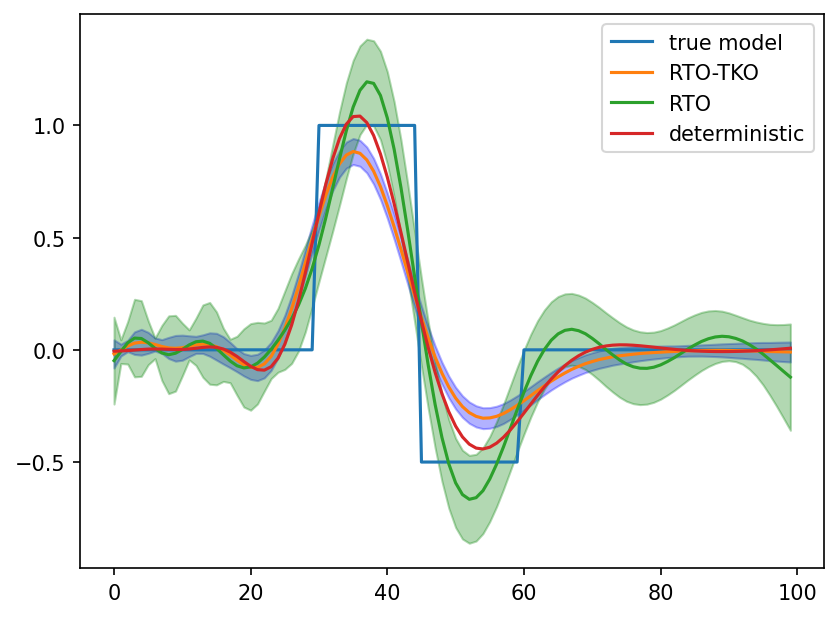

In [495]:
#some confidence interval
print(results.shape)
y = results.mean(axis=1)
y2 = rto_results.mean(axis=1)
ci = []
for ii in range(100):
    ci.append(1.96 * np.std(results[ii, :])/np.sqrt(results.shape[1]))

ci2 = []
for ii in range(100):
    ci2.append(1.96 * np.std(rto_results[ii, :])/np.sqrt(rto_results.shape[1]))

plt.fill_between(np.arange(100), (y-ci), (y+ci), color='b', alpha=.3)
plt.fill_between(np.arange(100), (y2-ci2), (y2+ci2), color='g', alpha=.3)
plt.plot(true_model, label='true model')
plt.plot(results.mean(axis=1), label='RTO-TKO')
plt.plot(rto_results.mean(axis=1), label='RTO')
plt.plot(m_max_post, label='deterministic')
plt.legend()


6.086186837424534 3.1265294782471504 323.3128691604149 402.0041438732432


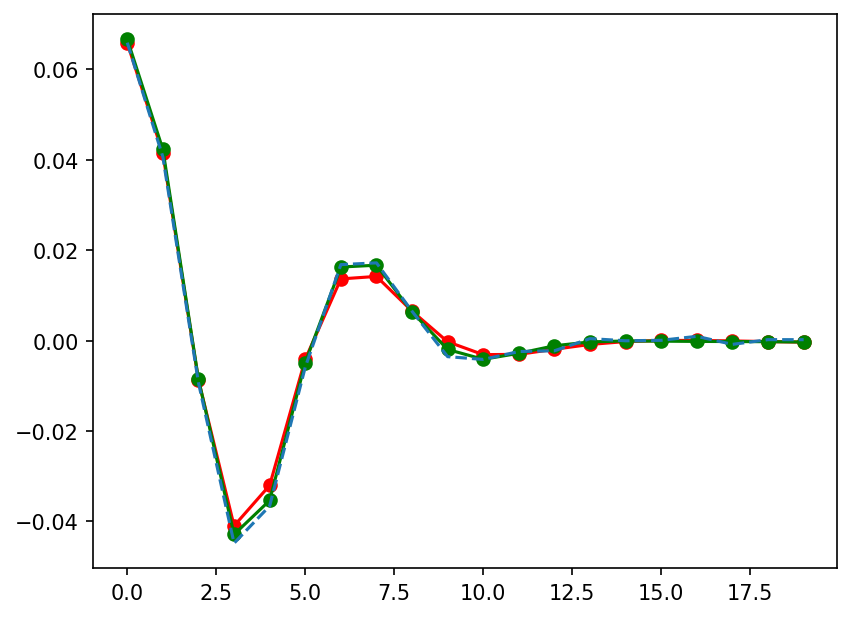

In [465]:
del_d = Wd @ (G @ results.mean(axis=1) - data_obj.dobs)
del_d2 = Wd @ (G @ rto_results.mean(axis=1) - data_obj.dobs)

Wm = np.sqrt(1e4) * np.eye(100)
del_m = Wm @ (results.mean(axis=1) - np.zeros(100))
del_m2 = Wm @ (rto_results.mean(axis=1) - np.zeros(100))
print(np.linalg.norm(del_d), np.linalg.norm(del_d2), np.linalg.norm(del_m), np.linalg.norm(del_m2))

plt.plot(G @ results.mean(axis=1), 'o-r')
plt.plot(G @ rto_results.mean(axis=1), 'o-g')
plt.plot(data_obj.dobs, '--')

## TKO

In [166]:
1 / 0.00018

5555.555555555556

In [686]:
from scipy.sparse import spdiags
mu_ref = 1e1
mu_new = 1e3
mu_d = np.sqrt(mu_ref) / mu_ref
rto_model = results.mean(axis=1).T[:, None]
Wd = np.diag(data_obj.standard_deviation)
# perturbed data step 2
perturbed_data_2 = np.random.multivariate_normal(data_obj.dobs, Wd, size=1)
# print(mu_d, Wd.shape, G.shape, rto_model.shape, perturbed_data_2.shape, (rto_model @ rto_model.T).shape)
# # A =  G.T @ Wd.T @ Wd @ G @ spdiags(rto_model[:, 0], 0, 100, 100)
# A = G.T @ Wd.T @ Wd @ G @ rto_model
# b =  G.T @ Wd.T @ Wd @ perturbed_data_2.T
# print(A.shape, b.shape)
# m_max_post = mu_d * np.linalg.solve(A, b)

# plt.hist(m_max_post)
# print(m_max_post.mean())
Cd = np.diag(1 / data_obj.standard_deviation)

# Example usage with the function f(x) = x^2 - 4x + 4
def objective_func(mu):
    r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T
    # print(0.5 * np.linalg.norm(r))
    return 0.5 * np.linalg.norm(r)

def gradient_func(mu):
    A = rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model
    B = rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
    # print(G)
    # return np.sqrt(mu_ref / mu) * rto_model.T @ G.T @ Cd.T @ Cd @ G @ rto_model - rto_model.T @ G.T @ Cd.T @ perturbed_data_2.T
    return np.sqrt(mu_ref / mu) * A - B

def gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x):
    x = initial_x
    v = []
    v2 = []
    for i in range(iterations):

        xprev = np.array([x]).copy()

        # get residual
        r = objective_func(x)

        # Calculate the gradient at the current point
        grad = gradient_func(x)

        Ag = G * grad
        alpha = (r*Ag).mean()/(Ag*Ag).mean()
        
        # Update x using the gradient and learning rate
        # update = learning_rate * grad
        # print(f"update: {update} alpha: {alpha}")

        x -= learning_rate * alpha * grad

        value = objective_func(x)
        
        # if r<  value:
        #     return xprev[0]
        #     x = xprev[0]
        #     x += learning_rate * alpha * grad

        if np.isnan(value):
    
            return xprev[0]

        # plt.plot(v, v2, '.')
        
        # Print the current iteration and the value of the objective function
        print(f"Iteration {i+1}: x = {x}, f(x) = {value}")
        v.append(x[0].copy())
        v2.append(value)

    plt.plot(v, v2, '-o')

    plt.show()
    
    return x

learning_rate = 1e-3
iterations = 50
initial_x = 30

result = gradient_descent(objective_func, gradient_func, learning_rate, iterations, initial_x)
print("Final result: x =", result, mu_ref)

A = G.T @ Cd.T @ Cd @ G + result * np.eye(G.shape[1])
b = G.T @ Cd.T @ Cd @ perturbed_data.T + result * np.eye(G.shape[1]) @ perturbed_model
m_max_post_t = np.linalg.solve(A, b)
# plt.plot(m_max_post_t)
# pts = []
# for m_ in np.arange(0.1, 10, 0.1):
#     pts.append(objective_func(m_))
# plt.plot(np.arange(0.1, 10, 0.1), pts)
# plt.show()
# print(gradient_func(initial_x))

Iteration 1: x = [[25.01152696]], f(x) = 72.8054347839024
Iteration 2: x = [[20.02042979]], f(x) = 72.8857520406171
Iteration 3: x = [[15.02382656]], f(x) = 73.06244881771191
Iteration 4: x = [[10.01511007]], f(x) = 73.51604601170718
Iteration 5: x = [[4.97529772]], f(x) = 75.26593055867734
Final result: x = [[4.97529772]] 10.0


C:\Users\johnk\AppData\Local\Temp\ipykernel_10548\1885732839.py:22: RuntimeWarning: invalid value encountered in sqrt
  r =  np.sqrt(mu_ref / mu) * Cd @ G @ rto_model  - Cd.T @ perturbed_data_2.T


In [500]:
mu_ref / mu

2.5

In [262]:
spdiags(rto_model[:, 0], 0, 100, 100).toarray()

array([[-0.02113162,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.00349408,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.01562298, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.01337209,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.01521247,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.01691418]])